In [1]:
pathtorepo = "C:\\Users\\Alex\\Desktop\\"

using Pkg
Pkg.activate(pathtorepo * "dynamical-systems\\env\\integrate\\")

using StaticArrays, DifferentialEquations, DynamicalSystems

x, y, z  = -10..10, -10..10,  -10..10
box = x × y × z

using CairoMakie
using GLMakie
using ForwardDiff
using LinearAlgebra

  Activating project at `C:\Users\Alex\Desktop\dynamical-systems\env\integrate`

In [2]:
@inbounds function Res(u, p, t)
    du1 = -u[2]-u[3]
    du2 = u[1]+p[1]*u[2]
    du3 = p[2]*u[1]-p[3]*u[3]+u[1]*u[3]
    return SVector(du1, du2, du3)
end
@inbounds function jac_res(u, p, t)
    SMatrix{3, 3}(0.0, 1.0, p[2]+u[3],
                -1.0, p[1], 0.0,
                -1.0, 0.0, -p[3]+u[1])
end

jac_res (generic function with 1 method)

In [3]:
time_set = (t = 500, Ttr = 250)
integ_set = (alg = Vern9(), abstol=1e-10, reltol=1e-10)

(alg = Vern9(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false), lazy = true), abstol = 1.0e-10, reltol = 1.0e-10)

In [194]:
 b = 0.3;  c = 5.5; a = 0.355;

In [195]:
u0 = SA[0.13060105886751308, 0.4782615699018184, 0.7435866656901606]
p = [a, b, c]
ds = CoupledODEs(Res, u0, p, diffeq = integ_set)

3-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      false
 dynamic rule:  Res
 ODE solver:    Vern9
 ODE kwargs:    (abstol = 1.0e-10, reltol = 1.0e-10)
 parameters:    [0.355, 0.3, 5.5]
 time:          0.0
 state:         [0.13060105886751308, 0.4782615699018184, 0.7435866656901606]


In [196]:
fp, ei, _ = fixedpoints(ds, box, jac_res)

(3-dimensional StateSpaceSet{Float64} with 1 points, Vector{ComplexF64}[[-5.446609483722405 + 0.0im, 0.150804741861202 - 0.9836193391018918im, 0.150804741861202 + 0.9836193391018918im]], Bool[0])

In [197]:
fixedpoint = fp[1]

Jacobian = jac_res(fixedpoint, p, 0)
eivecs = eigvecs(Jacobian)

vec_stable = real(eivecs[:, 3])
ϵ = 1e-10

shift = fixedpoint + vec_stable*ϵ

3-element SVector{3, Float64} with indices SOneTo(3):
  7.082378821831454e-11
 -1.4330006871096522e-11
  3.6494437722348705e-12

In [198]:
prob = ODEProblem(Res, shift, (0.0, 1000.0),p)

ODEProblem with uType SVector{3, Float64} and tType Float64. In-place: false
timespan: (0.0, 1000.0)
u0: 3-element SVector{3, Float64} with indices SOneTo(3):
  7.082378821831454e-11
 -1.4330006871096522e-11
  3.6494437722348705e-12

In [199]:
sol = solve(prob,alg = RK4(), abstol=1e-12, reltol=1e-12, maxiters = 5000000)

retcode: Success
Interpolation: 3rd order Hermite
t: 642234-element Vector{Float64}:
    0.0
    0.12322033241873315
    0.3230751185378107
    0.5665122419423746
    0.8801661412521254
    1.2457736762760137
    1.6684834737746816
    2.1316360468545734
    2.6261696766212386
    3.141296956033859
    ⋮
  999.9944412227508
  999.9951639829809
  999.9958859608381
  999.9966066734635
  999.9973265850721
  999.9980451799614
  999.9987629553899
  999.9994796292585
 1000.0
u: 642234-element Vector{SVector{3, Float64}}:
 [7.082378821831454e-11, -1.4330006871096522e-11, 3.6494437722348705e-12]
 [7.162283787894633e-11, -5.989252923061058e-12, 3.768862957437966e-12]
 [7.063657710032639e-11, 8.353283754830674e-12, 3.848196151656432e-12]
 [6.547050849559608e-11, 2.6513222766608053e-11, 3.739497689929124e-12]
 [5.241355963160064e-11, 4.942524813419694e-11, 3.2532331206488616e-12]
 [2.893859674877459e-11, 7.251253305227369e-11, 2.21235826726163e-12]
 [-6.3940583257034656e-12, 8.983754236368764e-11

In [200]:
ts, tf = 300000, 600000
idx, idy, idz = 1, 2, 3

GLMakie.activate!()
f = Figure(resolution = (1200, 800))
ax = Axis3(f[1, 1])
lines!(ax, sol[idx, ts:tf], sol[idy, ts:tf], sol[idz, ts:tf], linewidth = 1.0, color = :deeppink)

scatter!(fp[1][idx], fp[1][idy], fp[1][idz], color = :black)

display(GLMakie.Screen(), f)

GLMakie.Screen(...)

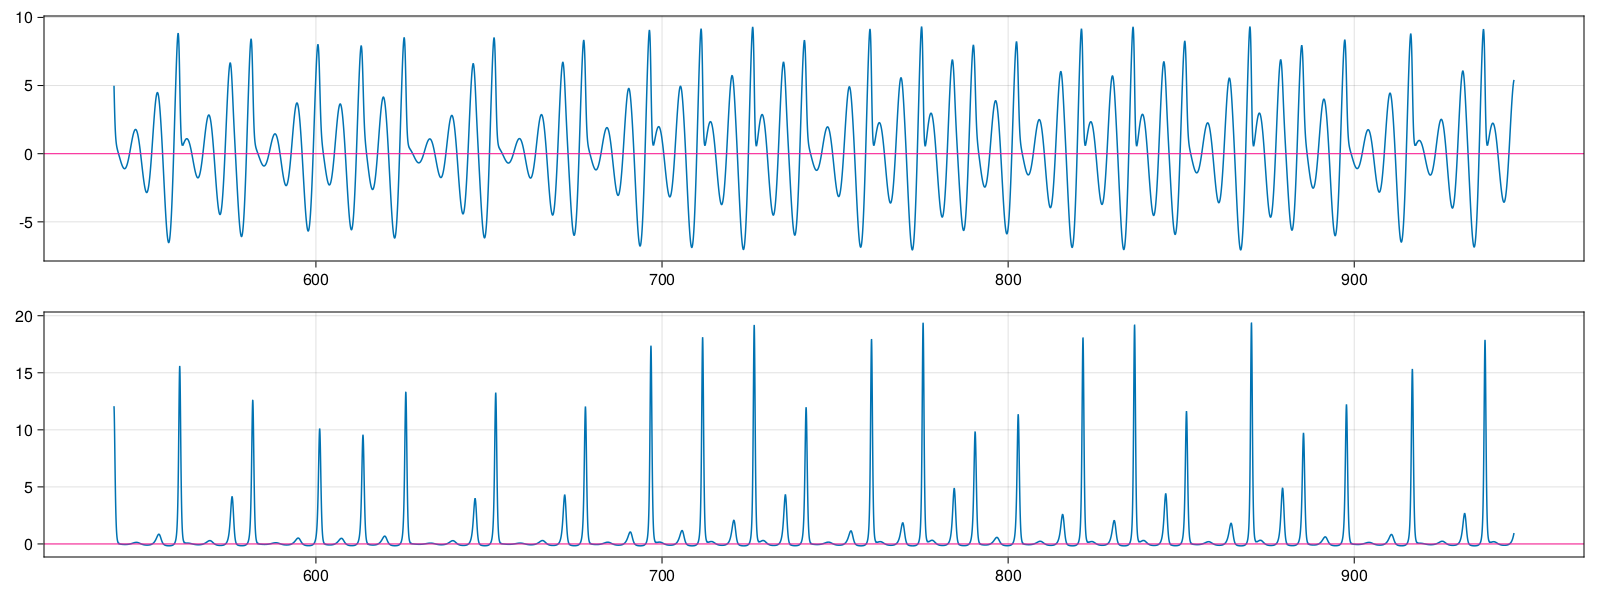

CairoMakie.Screen{IMAGE}


In [201]:
ts, tf = 300000, 600000

CairoMakie.activate!()

f = Figure(resolution = (1600, 600))
axx = Axis(f[1, 1])
axz = Axis(f[2, 1])

lines!(axx, sol.t[ts:tf], sol[1, ts:tf])
lines!(axz, sol.t[ts:tf], sol[3, ts:tf])

hlines!(axx, fp[1][1], linewidth = 1.0, color = :deeppink)
hlines!(axz, fp[1][3], linewidth = 1.0, color = :deeppink)

display(f)